In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Mark Down phase LSTM Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
(248, 15, 4)
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
(219, 15, 4)
            previous_1d      EMA_12   willr

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

mark down phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2014-09-15    41.320000  41.500600 -78.867942  75518300.0     2.0
2014-09-16    41.080002  41.435892 -83.396204  74723100.0     0.0
2014-09-17    41.759998  41.485755 -70.566080  76107100.0     2.0
2014-09-18    41.310001  41.458716 -59.927782  74746500.0     2.0
2014-09-19    40.490002  41.309683 -86.818145  72234300.0     2.0


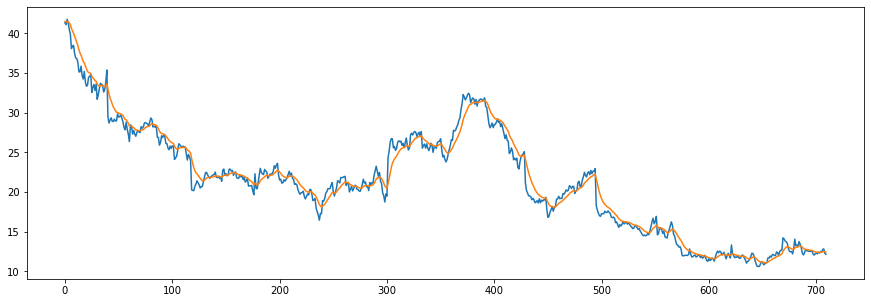

mark down phase data\10_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2011-01-03    36.860001  35.273652  -3.166198  661708900.0     2.0
2011-01-04    37.060001  35.548475 -19.542585  686583800.0     2.0
2011-01-05    37.900002  35.910248  -2.078970  718947200.0     2.0
2011-01-06    38.070000  36.242518  -4.500969  741451100.0     2.0
2011-01-07    38.900002  36.651361  -9.220953  780008000.0     0.0


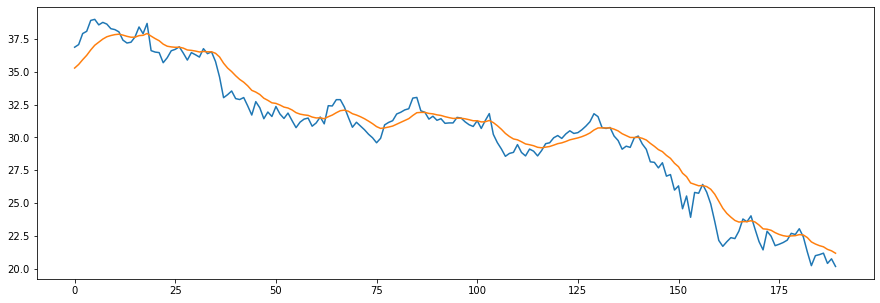

mark down phase data\1_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-06-11    36.040001  35.611612 -23.880572   71528339.0     2.0
2018-06-12    36.389999  35.731364 -10.820928   84527572.0     2.0
2018-06-13    36.720001  35.883462  -8.724777  100189617.0     2.0
2018-06-14    36.650002  36.001391 -11.498193   90429098.0     2.0
2018-06-15    36.720001  36.111947 -11.016875  105683003.0     2.0


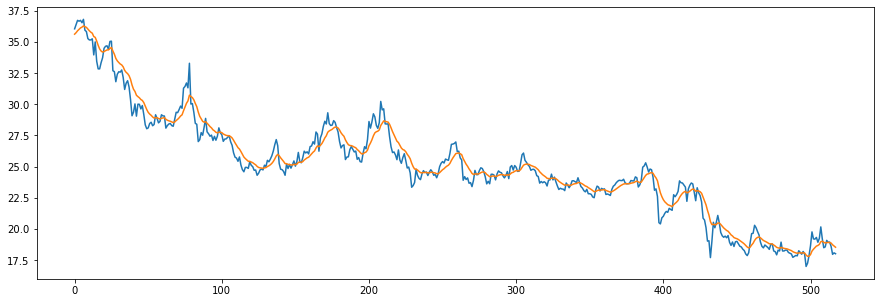

mark down phase data\2_acc_data.csv
            previous_1d    EMA_12    willr_14        OBV_7  labels
Date                                                              
2002-04-08     6.696734  6.639149  -28.571368  193154100.0     2.0
2002-04-09     6.696734  6.648008  -28.571368  193154100.0     2.0
2002-04-10     6.696734  6.655504  -28.571368  193154100.0     1.0
2002-04-11     6.405571  6.617053 -100.000000  178840437.0     2.0
2002-04-12     6.551152  6.606914  -62.500031  187124475.0     2.0


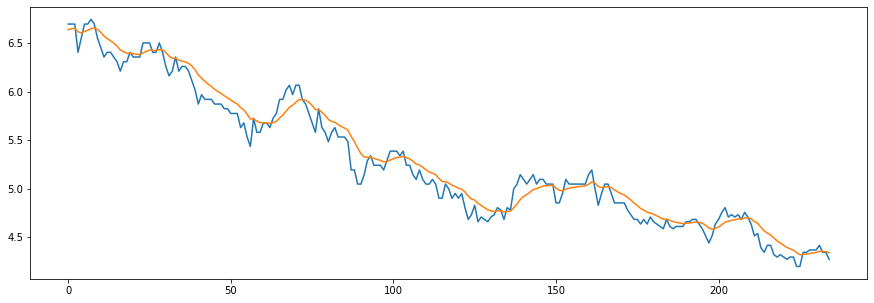

mark down phase data\3_acc_data.csv
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2007-07-09   517.000000  520.505488 -69.576057 -24963808.0     2.0
2007-07-10   516.000000  519.812336 -71.645539 -26753358.0     1.0
2007-07-11   510.000000  518.302746 -86.835412 -30126228.0     2.0
2007-07-12   514.099976  517.656166 -70.846456 -27607328.0     0.0
2007-07-13   528.400024  519.309067 -24.358887 -24528578.0     2.0


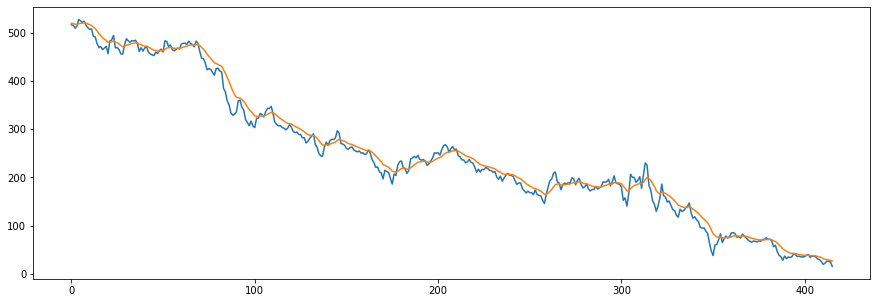

mark down phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


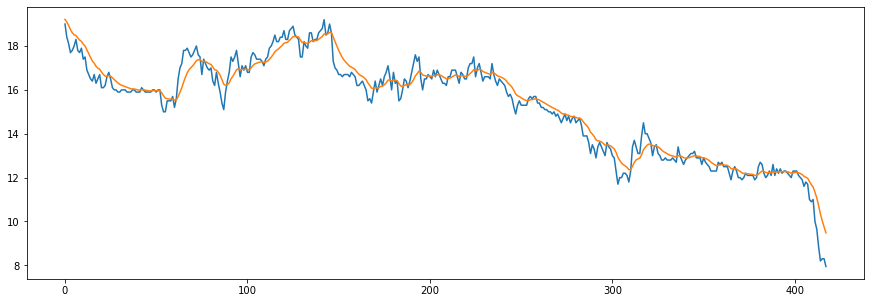

mark down phase data\5_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2015-04-13        12.10  11.228936 -17.272691  8.111586e+09     2.0
2015-04-14        12.26  11.387561  -9.999970  8.210947e+09     2.0
2015-04-15        12.42  11.546398  -6.956515  8.359031e+09     2.0
2015-04-16        12.90  11.754644  -3.703718  8.561712e+09     2.0
2015-04-17        13.34  11.998545  -7.361956  8.801107e+09     2.0


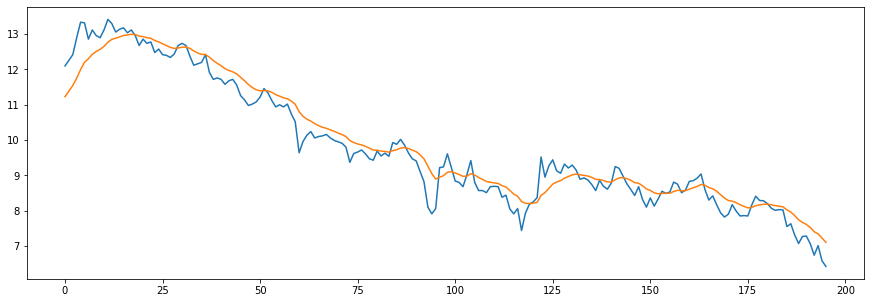

mark down phase data\6_acc_data.csv
            previous_1d    EMA_12    willr_14         OBV_7  labels
Date                                                               
2020-01-22         5.63  5.865838 -100.000000 -1.173373e+09     2.0
2020-01-23         5.70  5.840325  -85.106441 -1.050063e+09     2.0
2020-01-24         5.64  5.809505  -90.697690 -1.182421e+09     2.0
2020-01-29         5.62  5.780351  -91.111125 -1.235873e+09     2.0
2020-01-30         5.40  5.721835  -89.999980 -1.489349e+09     2.0


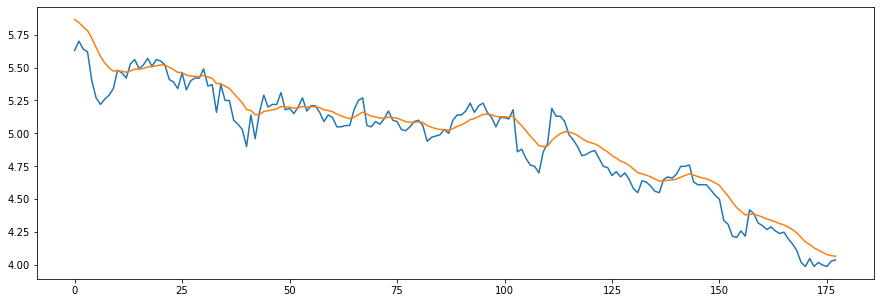

mark down phase data\7_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2001-04-16    29.000000  28.506905 -34.482761 -99375452.0     2.0
2001-04-17    29.180000  28.610458 -27.586194 -95843852.0     2.0
2001-04-18    28.879999  28.651926 -39.080497 -99108352.0     0.0
2001-04-19    30.709999  28.968553 -17.191311 -87511052.0     2.0
2001-04-20    30.299999  29.173391 -27.118670 -94318852.0     2.0


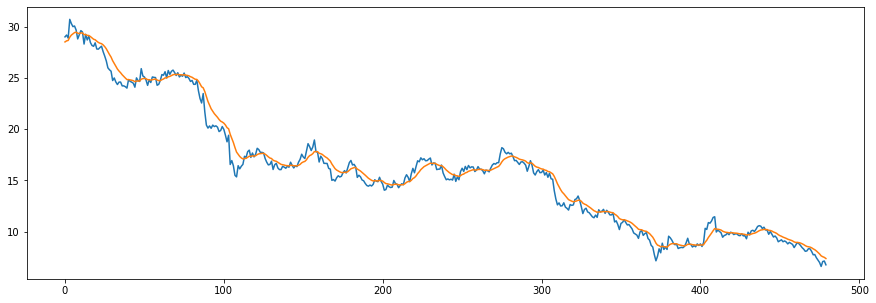

mark down phase data\8_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2004-12-20        14.34  14.249239 -25.423658 -383932352.0     2.0
2004-12-21        14.66  14.312433 -10.588248 -373260652.0     2.0
2004-12-22        14.71  14.373597 -12.162187 -364708252.0     2.0
2004-12-23        14.83  14.443813 -18.681330 -356318652.0     2.0
2004-12-27        14.80  14.498611 -21.978005 -359959452.0     2.0


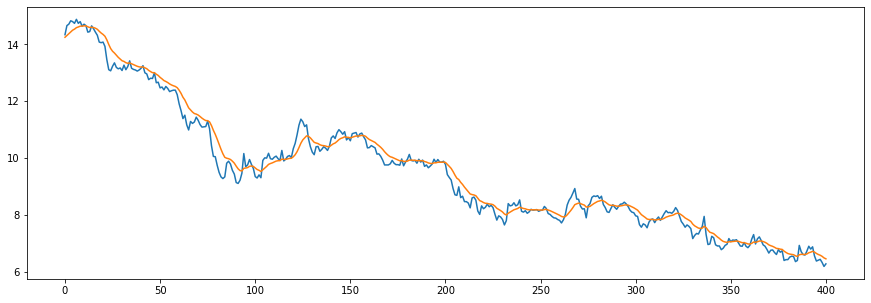

mark down phase data\9_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2015-03-16    16.200001  16.078687 -45.161237  1.717671e+09     2.0
2015-03-17    16.490000  16.141966 -13.978591  1.755402e+09     2.0
2015-03-18    16.389999  16.180125 -22.222293  1.734485e+09     2.0
2015-03-19    16.459999  16.223182 -14.444554  1.768233e+09     2.0
2015-03-20    16.340000  16.241154 -27.777760  1.750211e+09     2.0


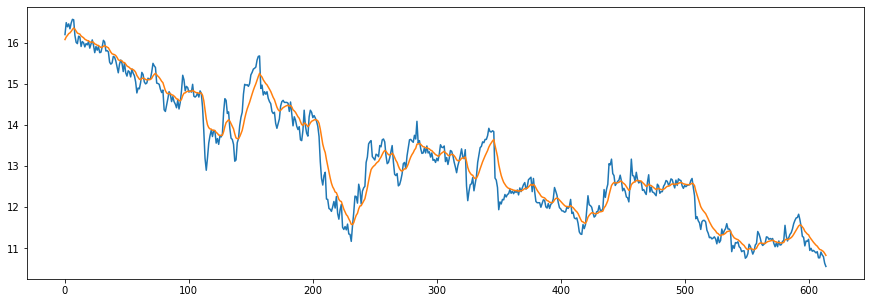

In [9]:
labels = []
sequential = []

for filepath in glob.iglob('mark down phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [10]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4203, 15, 4)

In [11]:
y = labels
y = np.array(y)
y.shape

(4203,)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 3811, 1.0: 202, 0.0: 190})

In [13]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [14]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/27 [>.............................] - ETA: 0s - loss: 0.4097 - accuracy: 0.5391 - mse: 0.3365 - weighted_accuracy: 0.2621 - weighted_mse: 0.5509WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
27/27 [==============================] - 2s 70ms/step - loss: 0.2957 - accuracy: 0.5158 - mse: 0.4516 - weighted_accuracy: 0.3603 - weighted_mse: 0.5174 - val_loss: 0.2995 - val_accuracy: 0.0488 - val_mse: 0.3521 - val_weighted_accuracy: 0.0488 - val_weighted_mse: 0.3521
Epoch 2/20
27/27 [==============================] - 1s 27ms/step - loss: 0.2116 - accuracy: 0.3745 - mse: 0.7517 - weighted_accuracy: 0.4740 - weighted_mse: 0.7242 - val_loss: 0.2904 - val_accuracy: 0.0476 - val_mse: 0.3748 - val_weighted_accuracy: 0.0

7/7 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.6484 - mse: 1.1921 - weighted_accuracy: 0.6484 - weighted_mse: 1.1921
Test loss: 0.16106021404266357
Test accuracy: 0.6484017968177795


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 43
actual holds but predicted sell: 19
actual predicted holds: 139
Percentage buys correct: 2.1739130434782608%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 91.44736842105263%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 42.22222222222222%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 86.84210526315789%


Capital: 100
Share price: $0.25353708443740985
Shares owned at the moment: 393
Cash capital at the moment: $0.08591561209219378


Pr

9/9 [==============================] - 0s 6ms/step - loss: 0.1710 - accuracy: 0.5216 - mse: 1.2777 - weighted_accuracy: 0.5216 - weighted_mse: 1.2777
Test loss: 0.1710028499364853
Test accuracy: 0.5215827226638794


number of predictions: 278
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 87
actual holds but predicted sell: 28
actual predicted holds: 134
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 12.121212121212121%
Percentage holds correct: 91.15646258503402%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.329896907216494%
Percentage high sells correct: 57.57575757575758%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.8942895141852923
Shares owned at the moment: 111
Cash capital at the moment: $0.46088205122748604


Pric

29/29 [==============================] - 0s 6ms/step - loss: 0.1671 - accuracy: 0.5583 - mse: 1.2347 - weighted_accuracy: 0.5583 - weighted_mse: 1.2347
Test loss: 0.16705265641212463
Test accuracy: 0.5583423972129822


number of predictions: 917
actual predicted buys: 17
actual buys but predicted sell: 2
actual buys but predicted hold: 27
actual sells but predicted buy: 7
actual predicted sells: 15
actual sells but predicted hold: 18
actual holds but predicted buy: 240
actual holds but predicted sell: 111
actual predicted holds: 480
Percentage buys correct: 6.4393939393939394%
Percentage sells correct: 11.71875%
Percentage holds correct: 91.42857142857143%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 84.16030534351145%


Capital: 100
Share price: $0.33905587250729685
Shares owned at the moment: 294
Cash capital at the moment: $0.04344680993257555


Price increase

Epoch 1/20
27/27 [==============================] - 2s 73ms/step - loss: 0.1425 - accuracy: 0.3882 - mse: 1.4825 - weighted_accuracy: 0.6970 - weighted_mse: 1.4344 - val_loss: 0.1779 - val_accuracy: 0.4269 - val_mse: 1.2718 - val_weighted_accuracy: 0.4269 - val_weighted_mse: 1.2718
Epoch 2/20
27/27 [==============================] - 0s 13ms/step - loss: 0.1421 - accuracy: 0.3599 - mse: 1.5224 - weighted_accuracy: 0.6885 - weighted_mse: 1.4505 - val_loss: 0.1735 - val_accuracy: 0.4780 - val_mse: 1.2720 - val_weighted_accuracy: 0.4780 - val_weighted_mse: 1.2720
Epoch 3/20
27/27 [==============================] - 0s 13ms/step - loss: 0.1409 - accuracy: 0.3498 - mse: 1.5735 - weighted_accuracy: 0.6872 - weighted_mse: 1.4906 - val_loss: 0.1720 - val_accuracy: 0.4828 - val_mse: 1.2974 - val_weighted_accuracy: 0.4828 - val_weighted_mse: 1.2974
Epoch 4/20
27/27 [==============================] - 0s 11ms/step - loss: 0.1397 - accuracy: 0.3828 - mse: 1.5618 - weighted_accuracy: 0.6889 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1737 - accuracy: 0.4932 - mse: 1.8348 - weighted_accuracy: 0.4932 - weighted_mse: 1.8348
Test loss: 0.17374756932258606
Test accuracy: 0.4931506812572479


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 38
actual holds but predicted sell: 65
actual predicted holds: 98
Percentage buys correct: 7.317073170731708%
Percentage sells correct: 9.722222222222221%
Percentage holds correct: 92.45283018867924%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.53658536585366%
Percentage high sells correct: 50.70422535211268%
Percentage mid holds correct: 83.9622641509434%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price

9/9 [==============================] - 0s 6ms/step - loss: 0.1764 - accuracy: 0.4568 - mse: 1.8933 - weighted_accuracy: 0.4568 - weighted_mse: 1.8933
Test loss: 0.17639413475990295
Test accuracy: 0.4568345248699188


number of predictions: 278
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 82
actual holds but predicted sell: 56
actual predicted holds: 111
Percentage buys correct: 9.782608695652174%
Percentage sells correct: 10.9375%
Percentage holds correct: 90.98360655737704%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.91304347826087%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 84.29752066115702%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previou

19/19 [==============================] - 0s 7ms/step - loss: 0.1715 - accuracy: 0.4824 - mse: 1.8257 - weighted_accuracy: 0.4824 - weighted_mse: 1.8257
Test loss: 0.17152994871139526
Test accuracy: 0.48235294222831726


number of predictions: 595
actual predicted buys: 24
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 21
actual sells but predicted hold: 4
actual holds but predicted buy: 117
actual holds but predicted sell: 177
actual predicted holds: 242
Percentage buys correct: 16.783216783216783%
Percentage sells correct: 10.5%
Percentage holds correct: 96.03174603174604%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 87.25099601593625%


Capital: 100
Share price: $0.9426119558767306
Shares owned at the moment: 105
Cash capital at the moment: $0.7535654306838779


Price increase from pre

29/29 [==============================] - 0s 8ms/step - loss: 0.1717 - accuracy: 0.4798 - mse: 1.8866 - weighted_accuracy: 0.4798 - weighted_mse: 1.8866
Test loss: 0.17168079316616058
Test accuracy: 0.47982552647590637


number of predictions: 917
actual predicted buys: 29
actual buys but predicted sell: 1
actual buys but predicted hold: 16
actual sells but predicted buy: 2
actual predicted sells: 28
actual sells but predicted hold: 10
actual holds but predicted buy: 213
actual holds but predicted sell: 235
actual predicted holds: 383
Percentage buys correct: 11.885245901639344%
Percentage sells correct: 10.606060606060606%
Percentage holds correct: 93.64303178484107%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 54.32098765432099%
Percentage high sells correct: 52.27272727272727%
Percentage mid holds correct: 85.57457212713936%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.143236689985

Epoch 1/20
27/27 [==============================] - 1s 30ms/step - loss: 0.1190 - accuracy: 0.5333 - mse: 1.8476 - weighted_accuracy: 0.7779 - weighted_mse: 1.8429 - val_loss: 0.1813 - val_accuracy: 0.4483 - val_mse: 1.9260 - val_weighted_accuracy: 0.4483 - val_weighted_mse: 1.9260
Epoch 2/20
27/27 [==============================] - 0s 16ms/step - loss: 0.1198 - accuracy: 0.5110 - mse: 1.8957 - weighted_accuracy: 0.7678 - weighted_mse: 1.8698 - val_loss: 0.1748 - val_accuracy: 0.4851 - val_mse: 1.8321 - val_weighted_accuracy: 0.4851 - val_weighted_mse: 1.8321
Epoch 3/20
27/27 [==============================] - 1s 20ms/step - loss: 0.1190 - accuracy: 0.5062 - mse: 1.9471 - weighted_accuracy: 0.7826 - weighted_mse: 1.9155 - val_loss: 0.1719 - val_accuracy: 0.5006 - val_mse: 1.9029 - val_weighted_accuracy: 0.5006 - val_weighted_mse: 1.9029
Epoch 4/20
27/27 [==============================] - 1s 21ms/step - loss: 0.1176 - accuracy: 0.5357 - mse: 1.9399 - weighted_accuracy: 0.7831 - weighted

7/7 [==============================] - 0s 9ms/step - loss: 0.1552 - accuracy: 0.6164 - mse: 2.3520 - weighted_accuracy: 0.6164 - weighted_mse: 2.3520
Test loss: 0.15523569285869598
Test accuracy: 0.6164383292198181


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 28
actual holds but predicted sell: 48
actual predicted holds: 125
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 12.727272727272727%
Percentage holds correct: 93.98496240601504%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.064516129032256%
Percentage high sells correct: 59.25925925925926%
Percentage mid holds correct: 84.9624060150376%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Pri

9/9 [==============================] - 0s 9ms/step - loss: 0.1606 - accuracy: 0.5683 - mse: 2.4975 - weighted_accuracy: 0.5683 - weighted_mse: 2.4975
Test loss: 0.16060909628868103
Test accuracy: 0.568345308303833


number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 56
actual holds but predicted sell: 47
actual predicted holds: 146
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 11.320754716981131%
Percentage holds correct: 90.12345679012346%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 62.264150943396224%
Percentage mid holds correct: 84.472049689441%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price

4         678.794088  


bear phase data


19/19 [==============================] - 0s 7ms/step - loss: 0.1532 - accuracy: 0.5916 - mse: 2.3440 - weighted_accuracy: 0.5916 - weighted_mse: 2.3440
Test loss: 0.15322987735271454
Test accuracy: 0.5915966629981995


number of predictions: 595
actual predicted buys: 23
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 23
actual sells but predicted hold: 3
actual holds but predicted buy: 88
actual holds but predicted sell: 142
actual predicted holds: 306
Percentage buys correct: 20.535714285714285%
Percentage sells correct: 13.855421686746988%
Percentage holds correct: 96.52996845425868%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 66.07142857142857%
Percentage high sells correct: 57.83132530120482%
Percentage mid holds correct: 87.34177215189874%


Capital: 100
Share price: $0.9229365241315254
Shares owned at the moment: 108
Cash 

29/29 [==============================] - 0s 5ms/step - loss: 0.1506 - accuracy: 0.6140 - mse: 2.4311 - weighted_accuracy: 0.6140 - weighted_mse: 2.4311
Test loss: 0.1505943089723587
Test accuracy: 0.6139585375785828


number of predictions: 917
actual predicted buys: 25
actual buys but predicted sell: 1
actual buys but predicted hold: 20
actual sells but predicted buy: 1
actual predicted sells: 26
actual sells but predicted hold: 13
actual holds but predicted buy: 153
actual holds but predicted sell: 166
actual predicted holds: 512
Percentage buys correct: 13.966480446927374%
Percentage sells correct: 13.471502590673575%
Percentage holds correct: 93.94495412844037%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 58.98876404494382%
Percentage high sells correct: 52.33160621761658%
Percentage mid holds correct: 86.60550458715596%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.14323668998568




RUNNING EPOCHS 60 - 80



Epoch 1/20
27/27 [==============================] - 1s 24ms/step - loss: 0.1006 - accuracy: 0.6437 - mse: 2.3317 - weighted_accuracy: 0.8406 - weighted_mse: 2.3991 - val_loss: 0.1699 - val_accuracy: 0.5529 - val_mse: 2.4333 - val_weighted_accuracy: 0.5529 - val_weighted_mse: 2.4333
Epoch 2/20
27/27 [==============================] - 0s 16ms/step - loss: 0.1019 - accuracy: 0.6211 - mse: 2.3924 - weighted_accuracy: 0.8306 - weighted_mse: 2.4501 - val_loss: 0.1637 - val_accuracy: 0.5743 - val_mse: 2.3586 - val_weighted_accuracy: 0.5743 - val_weighted_mse: 2.3586
Epoch 3/20
27/27 [==============================] - 0s 14ms/step - loss: 0.1010 - accuracy: 0.6169 - mse: 2.4384 - weighted_accuracy: 0.8294 - weighted_mse: 2.4900 - val_loss: 0.1610 - val_accuracy: 0.5993 - val_mse: 2.3994 - val_weighted_accuracy: 0.5993 - val_weighted_mse: 2.3994
Epoch 4/20
27/27 [==============================] - 0s 13ms/step - loss: 0.1000 - accuracy: 0.6398 - mse: 2.4608 - weighte

7/7 [==============================] - 0s 7ms/step - loss: 0.1449 - accuracy: 0.6804 - mse: 2.9027 - weighted_accuracy: 0.6804 - weighted_mse: 2.9027
Test loss: 0.14490973949432373
Test accuracy: 0.6803653240203857


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 22
actual holds but predicted sell: 40
actual predicted holds: 139
Percentage buys correct: 12.0%
Percentage sells correct: 14.893617021276595%
Percentage holds correct: 94.5578231292517%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.0%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 86.39455782312925%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase from previousl

9/9 [==============================] - 0s 7ms/step - loss: 0.1525 - accuracy: 0.6367 - mse: 3.1348 - weighted_accuracy: 0.6367 - weighted_mse: 3.1348
Test loss: 0.15250328183174133
Test accuracy: 0.6366906762123108


number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 42
actual holds but predicted sell: 39
actual predicted holds: 168
Percentage buys correct: 12.244897959183673%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 89.83957219251337%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 53.06122448979592%
Percentage high sells correct: 61.904761904761905%
Percentage mid holds correct: 84.94623655913979%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


P

19/19 [==============================] - 0s 6ms/step - loss: 0.1356 - accuracy: 0.6874 - mse: 2.8428 - weighted_accuracy: 0.6874 - weighted_mse: 2.8428
Test loss: 0.1355656087398529
Test accuracy: 0.6873949766159058


number of predictions: 595
actual predicted buys: 23
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 23
actual sells but predicted hold: 4
actual holds but predicted buy: 66
actual holds but predicted sell: 107
actual predicted holds: 363
Percentage buys correct: 25.84269662921348%
Percentage sells correct: 17.557251908396946%
Percentage holds correct: 96.8%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 65.1685393258427%
Percentage high sells correct: 60.30534351145038%
Percentage mid holds correct: 87.70053475935829%


Capital: 100
Share price: $0.7950467807041611
Shares owned at the moment: 125
Cash capital at the moment: $0.34585508111280205


Price increas

29/29 [==============================] - 0s 5ms/step - loss: 0.1369 - accuracy: 0.6947 - mse: 2.9845 - weighted_accuracy: 0.6947 - weighted_mse: 2.9845
Test loss: 0.13692478835582733
Test accuracy: 0.694656491279602


number of predictions: 917
actual predicted buys: 25
actual buys but predicted sell: 1
actual buys but predicted hold: 20
actual sells but predicted buy: 1
actual predicted sells: 25
actual sells but predicted hold: 14
actual holds but predicted buy: 124
actual holds but predicted sell: 120
actual predicted holds: 587
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 17.123287671232877%
Percentage holds correct: 94.52495974235104%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 57.718120805369125%
Percentage high sells correct: 57.534246575342465%
Percentage mid holds correct: 87.76167471819646%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.143236689985

Epoch 1/20
27/27 [==============================] - 1s 19ms/step - loss: 0.0837 - accuracy: 0.7207 - mse: 2.9321 - weighted_accuracy: 0.8894 - weighted_mse: 3.0562 - val_loss: 0.1609 - val_accuracy: 0.6552 - val_mse: 3.1574 - val_weighted_accuracy: 0.6552 - val_weighted_mse: 3.1574
Epoch 2/20
27/27 [==============================] - 0s 10ms/step - loss: 0.0854 - accuracy: 0.6984 - mse: 3.0018 - weighted_accuracy: 0.8769 - weighted_mse: 3.1174 - val_loss: 0.1615 - val_accuracy: 0.6397 - val_mse: 2.9728 - val_weighted_accuracy: 0.6397 - val_weighted_mse: 2.9728
Epoch 3/20
27/27 [==============================] - 0s 10ms/step - loss: 0.0844 - accuracy: 0.7094 - mse: 3.0375 - weighted_accuracy: 0.8731 - weighted_mse: 3.1608 - val_loss: 0.1579 - val_accuracy: 0.6397 - val_mse: 3.1188 - val_weighted_accuracy: 0.6397 - val_weighted_mse: 3.1188
Epoch 4/20
27/27 [==============================] - 0s 12ms/step - loss: 0.0842 - accuracy: 0.7145 - mse: 3.1223 - weighted_accuracy: 0.8829 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1354 - accuracy: 0.7260 - mse: 3.7636 - weighted_accuracy: 0.7260 - weighted_mse: 3.7636
Test loss: 0.1353796422481537
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 15
actual holds but predicted sell: 35
actual predicted holds: 151
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 14.634146341463415%
Percentage holds correct: 93.7888198757764%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 55.0%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase fr

2         -35.065241  


mark down phase data


9/9 [==============================] - 0s 8ms/step - loss: 0.1506 - accuracy: 0.6763 - mse: 4.0528 - weighted_accuracy: 0.6763 - weighted_mse: 4.0528
Test loss: 0.15055535733699799
Test accuracy: 0.6762589812278748


number of predictions: 278
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 10
actual holds but predicted buy: 38
actual holds but predicted sell: 30
actual predicted holds: 181
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.16256157635468%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 50.0%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 83.16831683168317%


Capital: 100
Share price: $0.8377868221289516
Shares owned at the moment: 119
Cash capital at th

29/29 [==============================] - 0s 5ms/step - loss: 0.1263 - accuracy: 0.7612 - mse: 3.7988 - weighted_accuracy: 0.7612 - weighted_mse: 3.7988
Test loss: 0.126254603266716
Test accuracy: 0.7611777782440186


number of predictions: 917
actual predicted buys: 24
actual buys but predicted sell: 1
actual buys but predicted hold: 21
actual sells but predicted buy: 0
actual predicted sells: 22
actual sells but predicted hold: 18
actual holds but predicted buy: 94
actual holds but predicted sell: 85
actual predicted holds: 652
Percentage buys correct: 20.338983050847457%
Percentage sells correct: 20.37037037037037%
Percentage holds correct: 94.35600578871201%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 58.97435897435897%
Percentage high sells correct: 60.18518518518518%
Percentage mid holds correct: 87.4095513748191%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.1432366899856845




6         -96.006693  



RUNNING EPOCHS 100 - 120



Epoch 1/20
27/27 [==============================] - 1s 22ms/step - loss: 0.0692 - accuracy: 0.7849 - mse: 3.7207 - weighted_accuracy: 0.9129 - weighted_mse: 3.8613 - val_loss: 0.1671 - val_accuracy: 0.6932 - val_mse: 4.1715 - val_weighted_accuracy: 0.6932 - val_weighted_mse: 4.1715
Epoch 2/20
27/27 [==============================] - 0s 15ms/step - loss: 0.0714 - accuracy: 0.7635 - mse: 3.7720 - weighted_accuracy: 0.9071 - weighted_mse: 3.8961 - val_loss: 0.1598 - val_accuracy: 0.7051 - val_mse: 3.9631 - val_weighted_accuracy: 0.7051 - val_weighted_mse: 3.9631
Epoch 3/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0710 - accuracy: 0.7680 - mse: 3.8107 - weighted_accuracy: 0.8988 - weighted_mse: 3.9408 - val_loss: 0.1592 - val_accuracy: 0.6861 - val_mse: 3.9187 - val_weighted_accuracy: 0.6861 - val_weighted_mse: 3.9187
Epoch 4/20
27/27 [==============================] - 1s 19ms/step - loss: 0.0700 - accuracy: 0.776

7/7 [==============================] - 0s 6ms/step - loss: 0.1254 - accuracy: 0.7808 - mse: 4.7081 - weighted_accuracy: 0.7808 - weighted_mse: 4.7081
Test loss: 0.12543681263923645
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 12
actual holds but predicted sell: 26
actual predicted holds: 163
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 18.75%
Percentage holds correct: 94.21965317919076%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 71.42857142857143%
Percentage high sells correct: 54.83870967741935%
Percentage mid holds correct: 86.70520231213872%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase

9/9 [==============================] - 0s 7ms/step - loss: 0.1498 - accuracy: 0.7302 - mse: 5.0067 - weighted_accuracy: 0.7302 - weighted_mse: 5.0067
Test loss: 0.14981761574745178
Test accuracy: 0.730215847492218


number of predictions: 278
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 13
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 30
actual holds but predicted sell: 20
actual predicted holds: 199
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 88.83928571428571%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 48.484848484848484%
Percentage high sells correct: 71.42857142857143%
Percentage mid holds correct: 83.40807174887892%


Capital: 100
Share price: $0.8377868221289516
Shares owned at the moment: 119
Cash capital at the moment: $0.029202429113055928


P

29/29 [==============================] - 0s 6ms/step - loss: 0.1158 - accuracy: 0.8113 - mse: 4.6640 - weighted_accuracy: 0.8113 - weighted_mse: 4.6640
Test loss: 0.11583642661571503
Test accuracy: 0.8113413453102112


number of predictions: 917
actual predicted buys: 22
actual buys but predicted sell: 0
actual buys but predicted hold: 24
actual sells but predicted buy: 0
actual predicted sells: 20
actual sells but predicted hold: 20
actual holds but predicted buy: 72
actual holds but predicted sell: 57
actual predicted holds: 702
Percentage buys correct: 23.404255319148938%
Percentage sells correct: 25.974025974025974%
Percentage holds correct: 94.10187667560322%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 63.44086021505376%
Percentage high sells correct: 62.33766233766234%
Percentage mid holds correct: 87.66756032171581%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.143236689985684




RUNNING EPOCHS 120 - 140



Epoch 1/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0566 - accuracy: 0.8340 - mse: 4.6499 - weighted_accuracy: 0.9331 - weighted_mse: 4.7396 - val_loss: 0.1691 - val_accuracy: 0.7693 - val_mse: 5.4638 - val_weighted_accuracy: 0.7693 - val_weighted_mse: 5.4638
Epoch 2/20
27/27 [==============================] - 0s 17ms/step - loss: 0.0593 - accuracy: 0.8239 - mse: 4.7076 - weighted_accuracy: 0.9312 - weighted_mse: 4.7904 - val_loss: 0.1657 - val_accuracy: 0.7539 - val_mse: 5.2176 - val_weighted_accuracy: 0.7539 - val_weighted_mse: 5.2176
Epoch 3/20
27/27 [==============================] - 1s 19ms/step - loss: 0.0598 - accuracy: 0.8129 - mse: 4.7523 - weighted_accuracy: 0.9233 - weighted_mse: 4.8549 - val_loss: 0.1671 - val_accuracy: 0.7099 - val_mse: 4.9897 - val_weighted_accuracy: 0.7099 - val_weighted_mse: 4.9897
Epoch 4/20
27/27 [==============================] - 1s 24ms/step - loss: 0.0593 - accuracy: 0.8221 - mse: 4.8413 - weigh

7/7 [==============================] - 0s 13ms/step - loss: 0.1275 - accuracy: 0.8539 - mse: 6.1935 - weighted_accuracy: 0.8539 - weighted_mse: 6.1935
Test loss: 0.12745551764965057
Test accuracy: 0.853881299495697


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 6
actual holds but predicted sell: 15
actual predicted holds: 180
Percentage buys correct: 25.0%
Percentage sells correct: 25.0%
Percentage holds correct: 94.24083769633508%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 62.5%
Percentage high sells correct: 65.0%
Percentage mid holds correct: 87.36842105263158%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase from previously bought: 596.7631298802885

9/9 [==============================] - 0s 7ms/step - loss: 0.1630 - accuracy: 0.7698 - mse: 6.5657 - weighted_accuracy: 0.7698 - weighted_mse: 6.5657
Test loss: 0.16298428177833557
Test accuracy: 0.769784152507782


number of predictions: 278
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 15
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 19
actual holds but predicted sell: 18
actual predicted holds: 212
Percentage buys correct: 5.0%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 88.7029288702929%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 55.0%
Percentage high sells correct: 68.42105263157895%
Percentage mid holds correct: 82.77310924369748%


Capital: 100
Share price: $0.8377868221289516
Shares owned at the moment: 119
Cash capital at the moment: $0.029202429113055928


Price increase from previousl

29/29 [==============================] - 0s 10ms/step - loss: 0.1151 - accuracy: 0.8430 - mse: 6.0633 - weighted_accuracy: 0.8430 - weighted_mse: 6.0633
Test loss: 0.11514101177453995
Test accuracy: 0.8429661989212036


number of predictions: 917
actual predicted buys: 20
actual buys but predicted sell: 0
actual buys but predicted hold: 26
actual sells but predicted buy: 0
actual predicted sells: 20
actual sells but predicted hold: 20
actual holds but predicted buy: 55
actual holds but predicted sell: 43
actual predicted holds: 733
Percentage buys correct: 26.666666666666668%
Percentage sells correct: 31.746031746031747%
Percentage holds correct: 94.09499358151476%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 63.513513513513516%
Percentage high sells correct: 73.01587301587301%
Percentage mid holds correct: 87.8048780487805%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.14323668998568

Epoch 1/20
27/27 [==============================] - 1s 23ms/step - loss: 0.0464 - accuracy: 0.8769 - mse: 5.8112 - weighted_accuracy: 0.9508 - weighted_mse: 5.7698 - val_loss: 0.1905 - val_accuracy: 0.7586 - val_mse: 6.6835 - val_weighted_accuracy: 0.7586 - val_weighted_mse: 6.6835
Epoch 2/20
27/27 [==============================] - 0s 14ms/step - loss: 0.0492 - accuracy: 0.8590 - mse: 5.8416 - weighted_accuracy: 0.9462 - weighted_mse: 5.7999 - val_loss: 0.1838 - val_accuracy: 0.7788 - val_mse: 6.8220 - val_weighted_accuracy: 0.7788 - val_weighted_mse: 6.8220
Epoch 3/20
27/27 [==============================] - 0s 15ms/step - loss: 0.0501 - accuracy: 0.8507 - mse: 5.9055 - weighted_accuracy: 0.9352 - weighted_mse: 5.8820 - val_loss: 0.1770 - val_accuracy: 0.7229 - val_mse: 6.2068 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 6.2068
Epoch 4/20
27/27 [==============================] - 0s 15ms/step - loss: 0.0505 - accuracy: 0.8620 - mse: 6.0271 - weighted_accuracy: 0.9395 - weighted

7/7 [==============================] - 0s 7ms/step - loss: 0.1369 - accuracy: 0.8676 - mse: 7.9422 - weighted_accuracy: 0.8676 - weighted_mse: 7.9422
Test loss: 0.13694633543491364
Test accuracy: 0.8675799369812012


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 4
actual holds but predicted sell: 10
actual predicted holds: 187
Percentage buys correct: 0.0%
Percentage sells correct: 23.076923076923077%
Percentage holds correct: 92.57425742574257%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 86.06965174129353%


Capital: 100
Share price: $0.3610464513446774
Shares owned at the moment: 276
Cash capital at the moment: $0.07714517229842954


Price increase from previously b

3         -97.604141  


bull phase data


7/7 [==============================] - 0s 6ms/step - loss: 0.1819 - accuracy: 0.7788 - mse: 6.8086 - weighted_accuracy: 0.7788 - weighted_mse: 6.8086
Test loss: 0.18194270133972168
Test accuracy: 0.7788461446762085


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 5
actual holds but predicted sell: 23
actual predicted holds: 161
Percentage buys correct: 0.0%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 90.4494382022472%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 0.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.7457627118644%


Capital: 100
Share price: $0.49345618842329086
Shares owned at the moment: 202
Cash capital at the moment: $0.047735025826114


Price i

29/29 [==============================] - 0s 7ms/step - loss: 0.1204 - accuracy: 0.8735 - mse: 7.7338 - weighted_accuracy: 0.8735 - weighted_mse: 7.7338
Test loss: 0.12042340636253357
Test accuracy: 0.8735005259513855


number of predictions: 917
actual predicted buys: 19
actual buys but predicted sell: 0
actual buys but predicted hold: 27
actual sells but predicted buy: 0
actual predicted sells: 17
actual sells but predicted hold: 23
actual holds but predicted buy: 39
actual holds but predicted sell: 27
actual predicted holds: 765
Percentage buys correct: 32.758620689655174%
Percentage sells correct: 38.63636363636363%
Percentage holds correct: 93.86503067484662%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 65.51724137931035%
Percentage high sells correct: 75.0%
Percentage mid holds correct: 87.59213759213759%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.07502692477278572


Price incr

Epoch 2/20
27/27 [==============================] - 1s 22ms/step - loss: 0.0409 - accuracy: 0.8837 - mse: 7.1684 - weighted_accuracy: 0.9572 - weighted_mse: 6.9279 - val_loss: 0.2040 - val_accuracy: 0.7895 - val_mse: 8.4087 - val_weighted_accuracy: 0.7895 - val_weighted_mse: 8.4087
Epoch 3/20
27/27 [==============================] - 1s 21ms/step - loss: 0.0435 - accuracy: 0.8742 - mse: 7.2719 - weighted_accuracy: 0.9478 - weighted_mse: 7.0485 - val_loss: 0.1874 - val_accuracy: 0.7717 - val_mse: 8.1632 - val_weighted_accuracy: 0.7717 - val_weighted_mse: 8.1632
Epoch 4/20
27/27 [==============================] - 1s 22ms/step - loss: 0.0416 - accuracy: 0.8840 - mse: 7.2866 - weighted_accuracy: 0.9515 - weighted_mse: 6.9848 - val_loss: 0.2225 - val_accuracy: 0.7432 - val_mse: 8.6622 - val_weighted_accuracy: 0.7432 - val_weighted_mse: 8.6622
Epoch 5/20
27/27 [==============================] - 1s 23ms/step - loss: 0.0384 - accuracy: 0.8983 - mse: 7.3522 - weighted_accuracy: 0.9607 - weighted

15/15 [==============================] - 0s 9ms/step - loss: 0.1906 - accuracy: 0.8191 - mse: 9.0944 - weighted_accuracy: 0.8191 - weighted_mse: 9.0944
Test loss: 0.19059589505195618
Test accuracy: 0.8191489577293396


number of predictions: 470
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 23
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 18
actual holds but predicted buy: 18
actual holds but predicted sell: 26
actual predicted holds: 382
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.30732860520095%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 71.42857142857143%
Percentage mid holds correct: 84.59715639810426%


Capital: 100
Share price: $0.6180997059475042
Shares owned at the moment: 161
Cash capital at the moment: $0.21228369764355648



19/19 [==============================] - 0s 13ms/step - loss: 0.0942 - accuracy: 0.9126 - mse: 9.4362 - weighted_accuracy: 0.9126 - weighted_mse: 9.4362
Test loss: 0.09419166296720505
Test accuracy: 0.9126050472259521


number of predictions: 595
actual predicted buys: 22
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 20
actual sells but predicted hold: 7
actual holds but predicted buy: 9
actual holds but predicted sell: 26
actual predicted holds: 501
Percentage buys correct: 70.96774193548387%
Percentage sells correct: 42.5531914893617%
Percentage holds correct: 96.90522243713733%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 87.09677419354838%
Percentage high sells correct: 78.72340425531915%
Percentage mid holds correct: 88.95348837209302%


Capital: 100
Share price: $0.9426119558767306
Shares owned at the moment: 105
Cash capital at the moment: $0.7535654306838779


Pr

Epoch 1/20
27/27 [==============================] - 1s 51ms/step - loss: 0.0322 - accuracy: 0.9191 - mse: 8.6858 - weighted_accuracy: 0.9643 - weighted_mse: 8.1524 - val_loss: 0.2272 - val_accuracy: 0.7943 - val_mse: 10.3368 - val_weighted_accuracy: 0.7943 - val_weighted_mse: 10.3368
Epoch 2/20
27/27 [==============================] - 1s 31ms/step - loss: 0.0339 - accuracy: 0.9054 - mse: 8.6597 - weighted_accuracy: 0.9652 - weighted_mse: 8.1292 - val_loss: 0.2294 - val_accuracy: 0.7919 - val_mse: 10.4279 - val_weighted_accuracy: 0.7919 - val_weighted_mse: 10.4279
Epoch 3/20
27/27 [==============================] - 1s 30ms/step - loss: 0.0367 - accuracy: 0.9012 - mse: 8.7360 - weighted_accuracy: 0.9597 - weighted_mse: 8.2347 - val_loss: 0.2067 - val_accuracy: 0.7895 - val_mse: 9.8250 - val_weighted_accuracy: 0.7895 - val_weighted_mse: 9.8250
Epoch 4/20
27/27 [==============================] - 1s 31ms/step - loss: 0.0372 - accuracy: 0.9024 - mse: 8.9529 - weighted_accuracy: 0.9544 - weig

7/7 [==============================] - 0s 7ms/step - loss: 0.1615 - accuracy: 0.8767 - mse: 11.8702 - weighted_accuracy: 0.8767 - weighted_mse: 11.8702
Test loss: 0.1614963561296463
Test accuracy: 0.8767123222351074


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 2
actual holds but predicted sell: 9
actual predicted holds: 190
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 10.0%
Percentage holds correct: 92.23300970873787%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.3610464513446774
Shares owned at the moment: 276
Cash capital at the moment: $0.07714517229842954


Price increase from previously

3         -97.604141  


bull phase data


7/7 [==============================] - 0s 8ms/step - loss: 0.2181 - accuracy: 0.7885 - mse: 9.8514 - weighted_accuracy: 0.7885 - weighted_mse: 9.8514
Test loss: 0.21805217862129211
Test accuracy: 0.7884615659713745


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 4
actual holds but predicted sell: 22
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 90.55555555555556%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 20.0%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 84.91620111731844%


Capital: 100
Share price: $0.49345618842329086
Shares owned at the moment: 202
Cash capital at the moment: $0.04773502

29/29 [==============================] - 0s 6ms/step - loss: 0.1413 - accuracy: 0.8866 - mse: 11.3489 - weighted_accuracy: 0.8866 - weighted_mse: 11.3489
Test loss: 0.14130595326423645
Test accuracy: 0.8865866661071777


number of predictions: 917
actual predicted buys: 19
actual buys but predicted sell: 0
actual buys but predicted hold: 27
actual sells but predicted buy: 0
actual predicted sells: 17
actual sells but predicted hold: 23
actual holds but predicted buy: 31
actual holds but predicted sell: 23
actual predicted holds: 777
Percentage buys correct: 38.0%
Percentage sells correct: 42.5%
Percentage holds correct: 93.9540507859734%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 68.0%
Percentage high sells correct: 77.5%
Percentage mid holds correct: 87.53026634382567%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.07502692477278572


Price increase from previously bought: 11.8778476

In [18]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0     -9.899283
1    205.510434
2     16.628167
3    -93.599337
4    104.923417
5     70.883812
6    384.026912
Name: Profit gained, dtype: float64

In [19]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


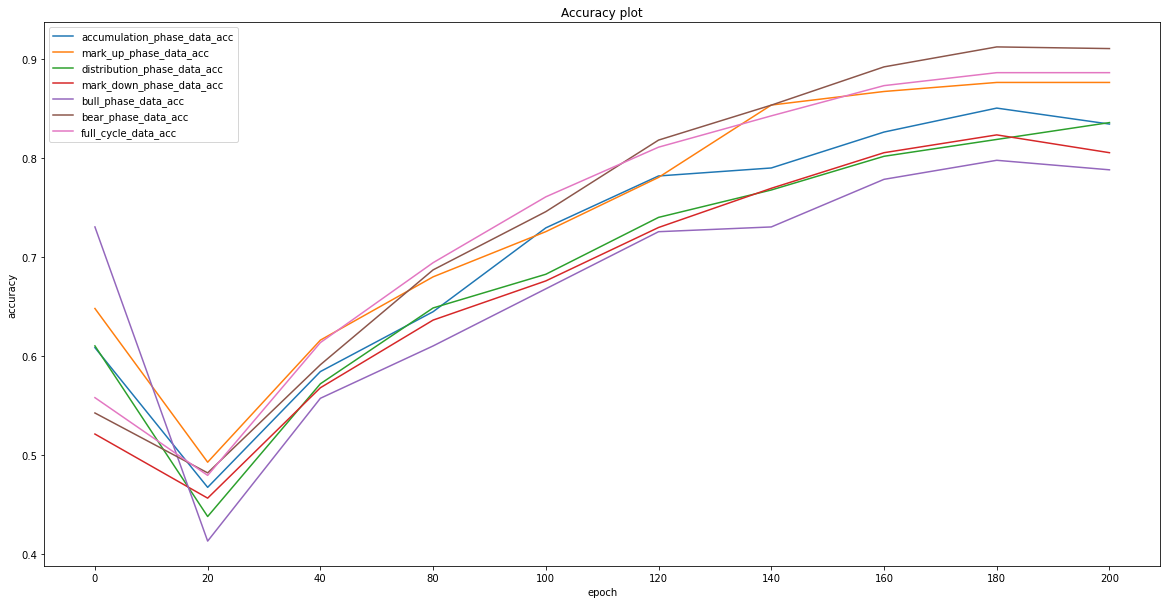

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

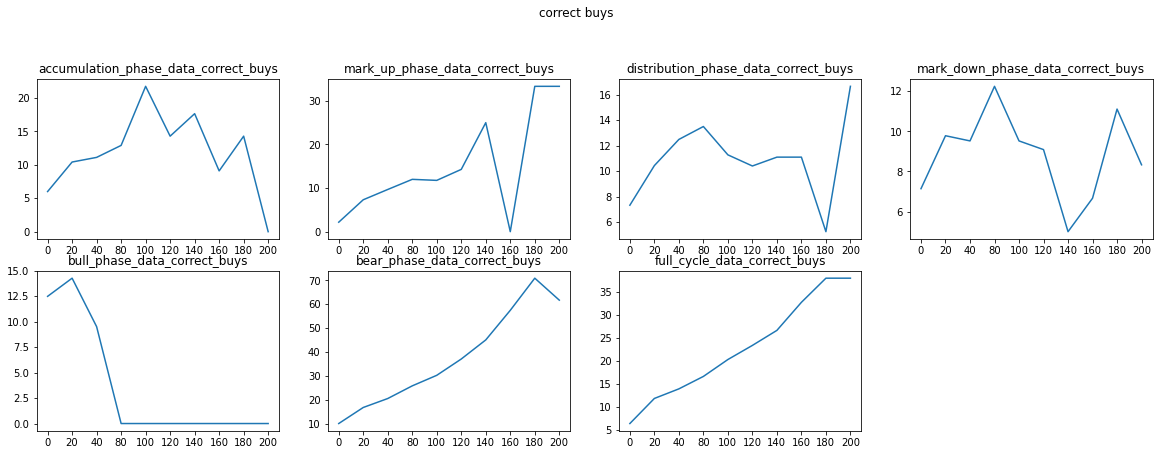

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

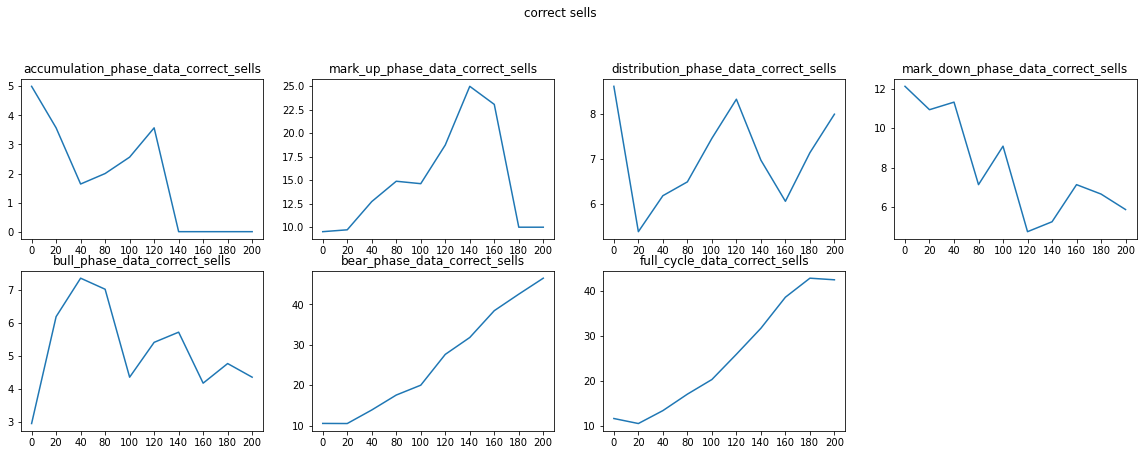

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

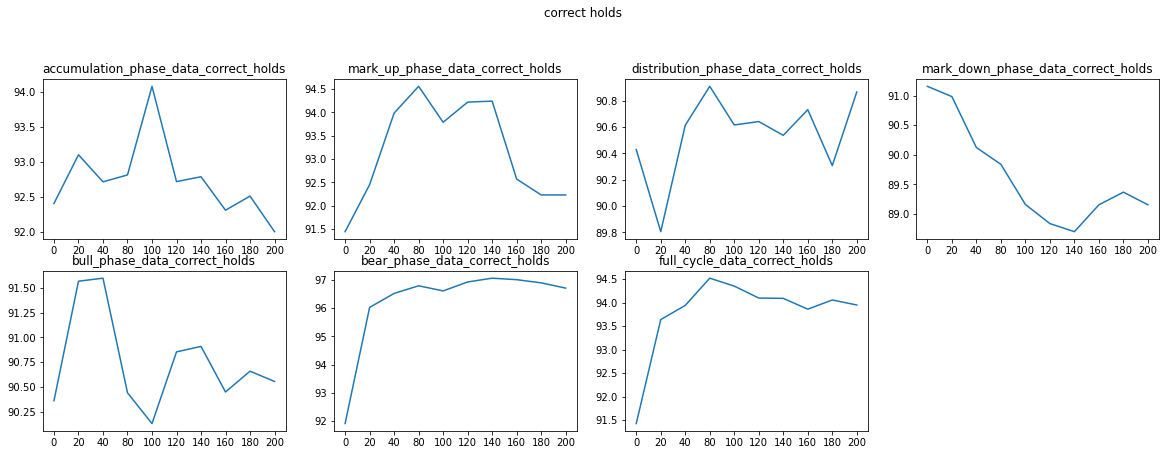

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

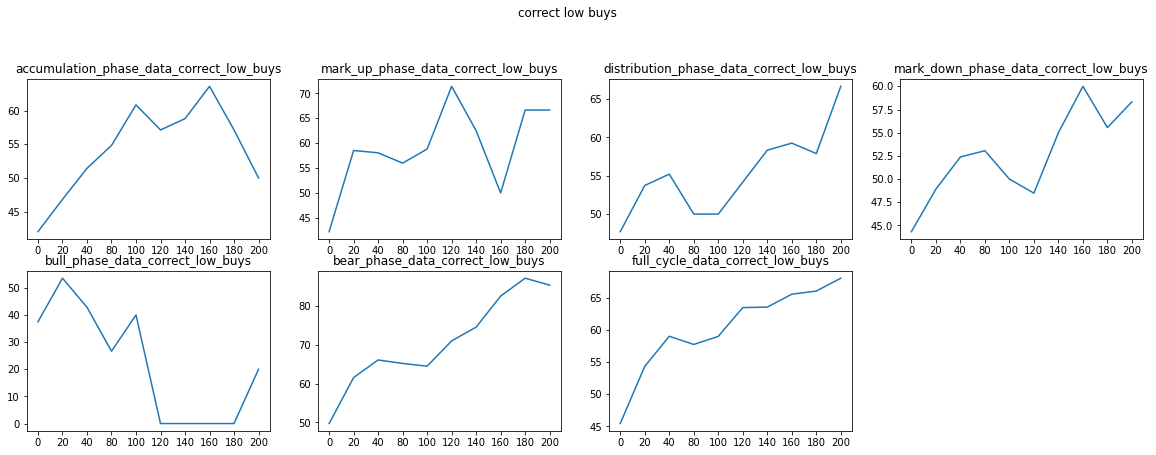

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

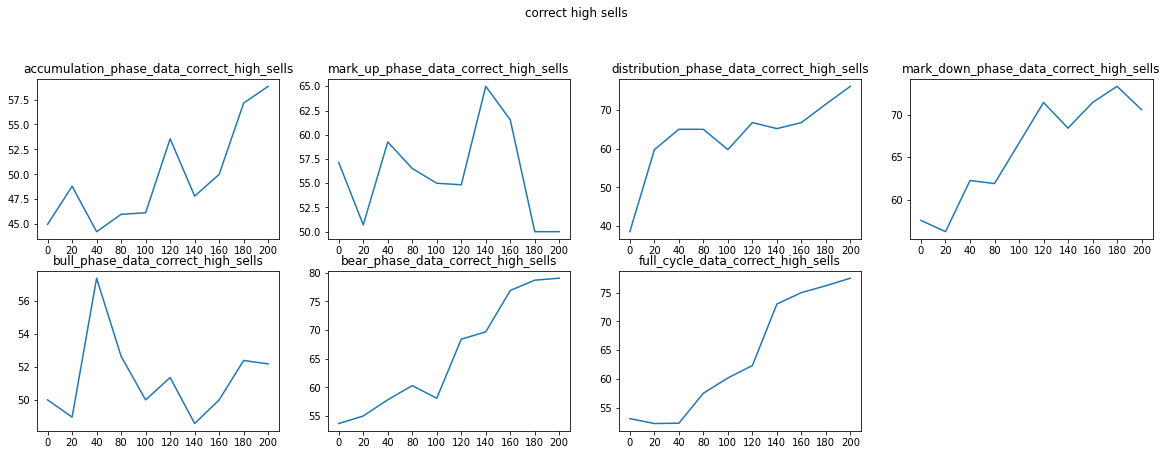

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

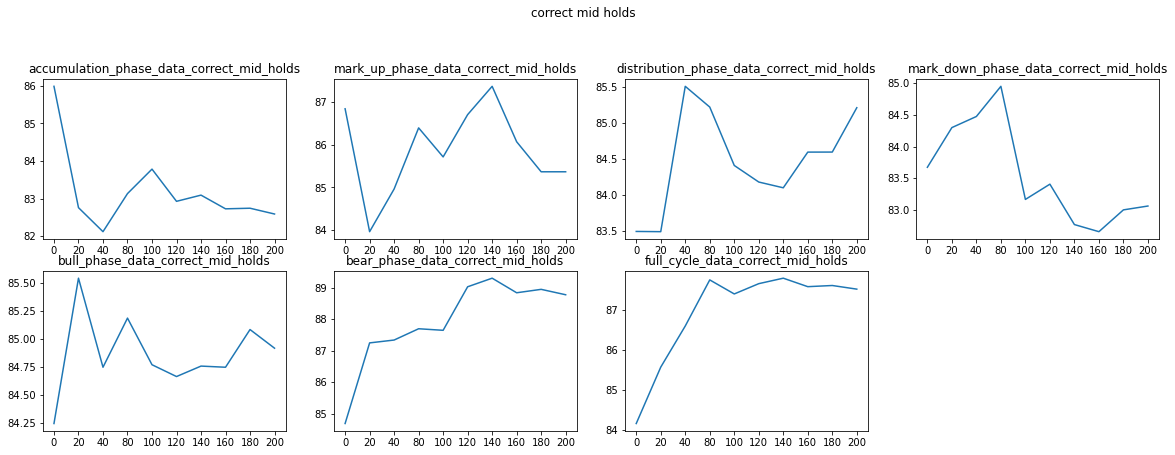

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

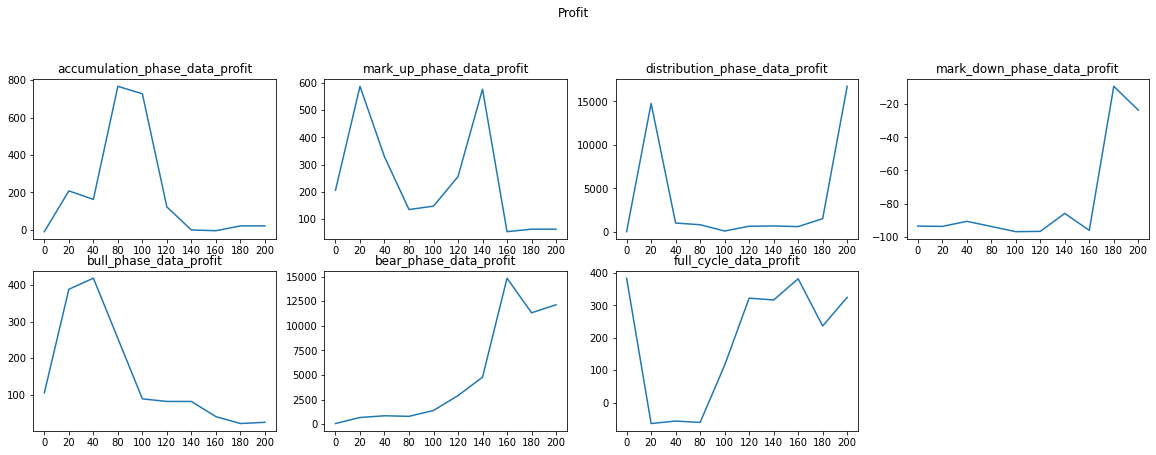

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")